<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Time Series Forecasting**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

print('Tensorflow version %s' % tf.__version__)

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

Tensorflow version 2.4.1
time: 2.68 ms (started: 2021-05-13 07:03:02 +00:00)


## **Load Data**

In [2]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "values"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
series.head()
dataset = series.copy()

time: 249 ms (started: 2021-05-13 07:03:02 +00:00)


In [3]:
# url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sh_unmelt_bq_raw.csv'
# sh_unmelt_bq_raw = pd.read_csv(url)
# sh_unmelt_bq_raw = sh_unmelt_bq_raw.sort_values('datum')
# sh_unmelt_bq_raw.head()

time: 987 µs (started: 2021-05-13 07:03:02 +00:00)


In [4]:
# dataset = sh_unmelt_bq_raw.copy()
# dataset = dataset.drop(columns=['Bergbau', 'Dienstleistungen', 'Energieversorgung','Erziehung', 'Finanzleistungen', 'Gastgewerbe','IT', 'Manufaktur', 'Sonstiges','Sozialwesen', 'Verkehr', 'Wohnungswesen'])
# dataset

time: 1.24 ms (started: 2021-05-13 07:03:02 +00:00)


In [5]:
# dataset = dataset.set_index('datum')
# dataset.index = pd.to_datetime(dataset.index, utc=False)
# dataset

time: 1.21 ms (started: 2021-05-13 07:03:02 +00:00)


#### **Set input data**

In [6]:
# Set data
data = dataset.copy()

# Set seed for reproducibility
tf.random.set_seed(7)

time: 2.36 ms (started: 2021-05-13 07:03:02 +00:00)


#### **Normalize input data**

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

time: 4.34 ms (started: 2021-05-13 07:03:02 +00:00)


In [8]:
print(dataset.shape)
# print(dataset.dtype)

(2516, 1)
time: 2.14 ms (started: 2021-05-13 07:03:02 +00:00)


In [9]:
# Display dataset
data [0:10] # Display first 10 values

array([[0.03804384],
       [0.03729827],
       [0.04110461],
       [0.03559523],
       [0.03736499],
       [0.03822044],
       [0.03938589],
       [0.03860499],
       [0.0393702 ],
       [0.0380831 ]])

time: 23.1 ms (started: 2021-05-13 07:03:02 +00:00)


#### **Train & Test Split**

In [10]:
# Train & Test Split in % of complete dataset
split = 0.8
train_size = int(len(data) * split)
test_size = len(dataset) - train_size
train, test = data[0:train_size,:], data[train_size:len(dataset),:]

time: 4.59 ms (started: 2021-05-13 07:03:02 +00:00)


In [11]:
train [0:10] # Display first 10 values

array([[0.03804384],
       [0.03729827],
       [0.04110461],
       [0.03559523],
       [0.03736499],
       [0.03822044],
       [0.03938589],
       [0.03860499],
       [0.0393702 ],
       [0.0380831 ]])

time: 7.44 ms (started: 2021-05-13 07:03:02 +00:00)


In [12]:
test [0:10] # Display first 10 values

array([[0.75495281],
       [0.74558638],
       [0.75050985],
       [0.74874529],
       [0.70478858],
       [0.66059551],
       [0.68013179],
       [0.65490784],
       [0.61783611],
       [0.64640014]])

time: 9.74 ms (started: 2021-05-13 07:03:02 +00:00)


Now train & test data have been separated. 

We need to divide by feature input (X) and prediction variable (Y).

For both train and test dataset

#### **Window & Reshape**

In [13]:
window = 15 # Use (t), (t-1) and (t-2) as input variables X
features = 1 # we have only one time series

time: 2.37 ms (started: 2021-05-13 07:03:02 +00:00)


In [14]:
# Convert an array of values into a dataset matrix
def create_dataset(data, window=window):
    dataX, dataY = [], []
    for i in range(len(data)-window-1):
        a = data[i:(i+window), 0]
        dataX.append(a)
        dataY.append(data[i + window, 0])
    return np.array(dataX), np.array(dataY)

# X is input data = value (at t, and t-1, t-2, depending on window size)
# Y is target data = value at t+1
# Each is additionally divided into train and test set

time: 10.4 ms (started: 2021-05-13 07:03:02 +00:00)


In [15]:
# Reshape into X=t and Y=t+1 and get as arrays
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

time: 8.8 ms (started: 2021-05-13 07:03:02 +00:00)


In [16]:
print(trainX.shape)

(1996, 15)
time: 3.08 ms (started: 2021-05-13 07:03:02 +00:00)


In [17]:
print(trainY.shape)

(1996,)
time: 4.95 ms (started: 2021-05-13 07:03:02 +00:00)


In [18]:
# X input has 3 (= window size) values at each step
trainX [0:10] # Display first 10 values

array([[0.03804384, 0.03729827, 0.04110461, 0.03559523, 0.03736499,
        0.03822044, 0.03938589, 0.03860499, 0.0393702 , 0.0380831 ,
        0.04129297, 0.04008045, 0.0420464 , 0.04108108, 0.0418816 ],
       [0.03729827, 0.04110461, 0.03559523, 0.03736499, 0.03822044,
        0.03938589, 0.03860499, 0.0393702 , 0.0380831 , 0.04129297,
        0.04008045, 0.0420464 , 0.04108108, 0.0418816 , 0.03884828],
       [0.04110461, 0.03559523, 0.03736499, 0.03822044, 0.03938589,
        0.03860499, 0.0393702 , 0.0380831 , 0.04129297, 0.04008045,
        0.0420464 , 0.04108108, 0.0418816 , 0.03884828, 0.03743562],
       [0.03559523, 0.03736499, 0.03822044, 0.03938589, 0.03860499,
        0.0393702 , 0.0380831 , 0.04129297, 0.04008045, 0.0420464 ,
        0.04108108, 0.0418816 , 0.03884828, 0.03743562, 0.03545789],
       [0.03736499, 0.03822044, 0.03938589, 0.03860499, 0.0393702 ,
        0.0380831 , 0.04129297, 0.04008045, 0.0420464 , 0.04108108,
        0.0418816 , 0.03884828, 0.03743562, 

time: 7.81 ms (started: 2021-05-13 07:03:02 +00:00)


In [19]:
# Y output has here only one value (t+1) at each step
trainY

array([0.03884828, 0.03743562, 0.03545789, ..., 0.75053351, 0.74601968,
       0.75084863])

time: 4.49 ms (started: 2021-05-13 07:03:02 +00:00)


In [20]:
trainX.shape[0]

1996

time: 4.5 ms (started: 2021-05-13 07:03:02 +00:00)


In [21]:
trainX.shape[1]

15

time: 4.8 ms (started: 2021-05-13 07:03:02 +00:00)


#### **Reshape Data Format for LSTM**

In [22]:
# Reshape Data Format for LSTM (simple model)

# Data is in shape **[samples, features]**. LSTM expects **[samples, time steps, features]**
# Reminder 2D array: shape (n,m), n [0] = rows (time steps), m [1] = column(s)
# Shape: First Block: t, t+1, t+2. Second: t+1, t+2, t+3. Third: t+2, t+3, t+4.
# Approach 1: Use past observations as separate input features =(trainX.shape[0], features, trainX.shape[1])

# trainX = np.reshape(trainX, (trainX.shape[0], features, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], features, testX.shape[1]))

time: 2.38 ms (started: 2021-05-13 07:03:02 +00:00)


In [23]:
# Approach 2: Use past observations as time steps of the one input feature

trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], features))
testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], features))
trainX

<tf.Tensor: shape=(1996, 15, 1), dtype=float64, numpy=
array([[[0.03804384],
        [0.03729827],
        [0.04110461],
        ...,
        [0.0420464 ],
        [0.04108108],
        [0.0418816 ]],

       [[0.03729827],
        [0.04110461],
        [0.03559523],
        ...,
        [0.04108108],
        [0.0418816 ],
        [0.03884828]],

       [[0.04110461],
        [0.03559523],
        [0.03736499],
        ...,
        [0.0418816 ],
        [0.03884828],
        [0.03743562]],

       ...,

       [[0.65319059],
        [0.66784282],
        [0.68161278],
        ...,
        [0.71888154],
        [0.72496299],
        [0.73937896]],

       [[0.66784282],
        [0.68161278],
        [0.68470081],
        ...,
        [0.72496299],
        [0.73937896],
        [0.75053351]],

       [[0.68161278],
        [0.68470081],
        [0.69717095],
        ...,
        [0.73937896],
        [0.75053351],
        [0.74601968]]])>

time: 45.3 ms (started: 2021-05-13 07:03:02 +00:00)


In [24]:
print(trainX.shape)

(1996, 15, 1)
time: 2.92 ms (started: 2021-05-13 07:03:03 +00:00)


In [25]:
trainX [0:10] # Display first 10 values

<tf.Tensor: shape=(10, 15, 1), dtype=float64, numpy=
array([[[0.03804384],
        [0.03729827],
        [0.04110461],
        [0.03559523],
        [0.03736499],
        [0.03822044],
        [0.03938589],
        [0.03860499],
        [0.0393702 ],
        [0.0380831 ],
        [0.04129297],
        [0.04008045],
        [0.0420464 ],
        [0.04108108],
        [0.0418816 ]],

       [[0.03729827],
        [0.04110461],
        [0.03559523],
        [0.03736499],
        [0.03822044],
        [0.03938589],
        [0.03860499],
        [0.0393702 ],
        [0.0380831 ],
        [0.04129297],
        [0.04008045],
        [0.0420464 ],
        [0.04108108],
        [0.0418816 ],
        [0.03884828]],

       [[0.04110461],
        [0.03559523],
        [0.03736499],
        [0.03822044],
        [0.03938589],
        [0.03860499],
        [0.0393702 ],
        [0.0380831 ],
        [0.04129297],
        [0.04008045],
        [0.0420464 ],
        [0.04108108],
        [0.0418816 

time: 10.1 ms (started: 2021-05-13 07:03:03 +00:00)


In [26]:
print(testX.shape)

(488, 15, 1)
time: 2.37 ms (started: 2021-05-13 07:03:03 +00:00)


#### **Model Training**

In [27]:
# Set Hyperparameter
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = 'mean_squared_error'
activation = 'relu'
epochs = 20
verbose = 1
units = 1 # internal LSTM units
repeat = 1
batch_size = None

time: 6.59 ms (started: 2021-05-13 07:03:03 +00:00)


In [28]:
model = keras.Sequential(name="my_sequential")

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

# Add a LSTM layer with internal units.
model.add(layers.LSTM(units, input_shape=(window, features), return_sequences=False, activation=activation, name="layer1"))

# Add a Dense layer with 1 unit
# model.add(layers.Dense(1, name="layer2"))

# Call model on a test input
trainY = model(trainX)

time: 188 ms (started: 2021-05-13 07:03:03 +00:00)


In [29]:
model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
layer2 (Dense)               (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
time: 3.14 ms (started: 2021-05-13 07:03:03 +00:00)


In [30]:
trainY.shape

TensorShape([1996, 1])

time: 4.76 ms (started: 2021-05-13 07:03:03 +00:00)


In [31]:
# model.weights

time: 934 µs (started: 2021-05-13 07:03:03 +00:00)


In [32]:
# print("Number of weights after calling the model:", len(model.weights))

time: 1.58 ms (started: 2021-05-13 07:03:03 +00:00)


In [33]:
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['accuracy'])

time: 33.7 ms (started: 2021-05-13 07:03:03 +00:00)


In [34]:
# Prepare visualisation - Plot Losses Keras TF (simple)
!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF

# Select visualization method
callbacks = [PlotLossesKerasTF()]

time: 3.05 s (started: 2021-05-13 07:03:03 +00:00)


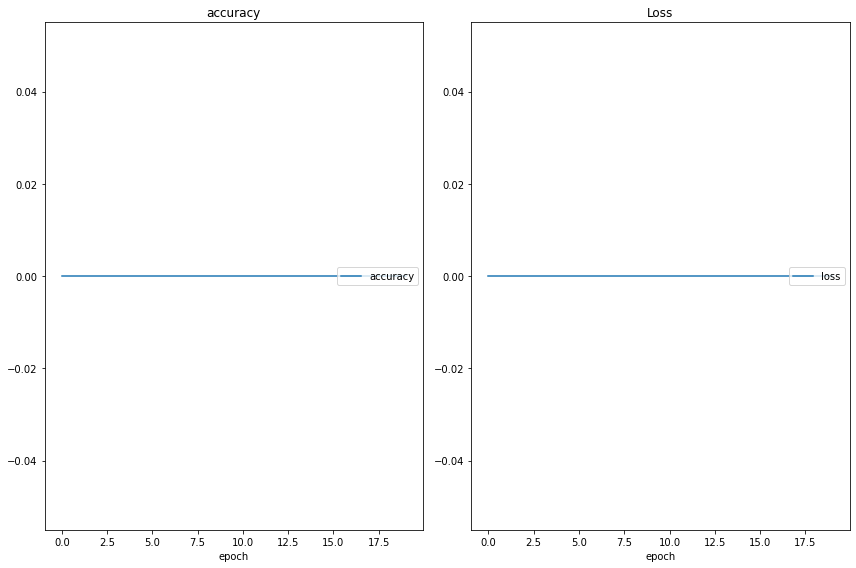

accuracy
	accuracy         	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)


time: 17.4 s (started: 2021-05-13 07:03:06 +00:00)


In [35]:
# Train model
model.fit(trainX,
          trainY, 
          epochs=epochs, 
          verbose=verbose, 
          shuffle=False, 
          callbacks=callbacks)

#### **Make Predictions**

In [36]:
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

time: 360 ms (started: 2021-05-13 07:03:23 +00:00)


#### **Predictions (Train & Test)**

**Test Predict**

In [37]:
testPredict [0:10]

array([[-0.22120234],
       [-0.22234732],
       [-0.22332942],
       [-0.22456348],
       [-0.22442627],
       [-0.22549218],
       [-0.22781086],
       [-0.22735196],
       [-0.22692727],
       [-0.22390339]], dtype=float32)

time: 4.92 ms (started: 2021-05-13 07:03:24 +00:00)


In [38]:
testPredict = scaler.inverse_transform(testPredict)
testPredict [0:10]

array([[-63.579906],
       [-65.03337 ],
       [-66.28008 ],
       [-67.846634],
       [-67.672455],
       [-69.02555 ],
       [-71.96895 ],
       [-71.38641 ],
       [-70.84729 ],
       [-67.00869 ]], dtype=float32)

time: 5.86 ms (started: 2021-05-13 07:03:24 +00:00)


**Train Predict**

In [39]:
trainPredict [0:10]

array([[-0.02393798],
       [-0.02360448],
       [-0.02311775],
       [-0.02244103],
       [-0.0219822 ],
       [-0.02204184],
       [-0.02263877],
       [-0.02335093],
       [-0.02445221],
       [-0.02585679]], dtype=float32)

time: 5.13 ms (started: 2021-05-13 07:03:24 +00:00)


In [40]:
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict [0:10]

array([[186.83324],
       [187.25659],
       [187.87447],
       [188.7335 ],
       [189.31596],
       [189.24025],
       [188.48248],
       [187.57848],
       [186.18047],
       [184.39745]], dtype=float32)

time: 6.61 ms (started: 2021-05-13 07:03:24 +00:00)


#### **Actual (Train & Test)**

**Test Actual**

In [41]:
testY [0:10]

array([0.69735212, 0.70434739, 0.70063709, 0.71651827, 0.72987858,
       0.70982235, 0.69914034, 0.67140349, 0.67880842, 0.68826937])

time: 5.05 ms (started: 2021-05-13 07:03:24 +00:00)


In [42]:
testY = scaler.inverse_transform([testY])
testY [0:10]

array([[1102.459961, 1111.339966, 1106.630005, 1126.790039, 1143.75    ,
        1118.290039, 1104.72998 , 1069.52002 , 1078.920044, 1090.930054,
        1095.060059, 1109.640015, 1126.      , 1160.040039, 1164.5     ,
        1138.170044, 1149.48999 , 1149.579956, 1135.72998 , 1099.819946,
        1097.709961, 1090.880005, 1049.079956, 1021.570007, 1053.209961,
        1005.099976, 1004.559998, 1031.790039, 1006.469971, 1013.409973,
        1025.140015, 1027.810059, 1007.039978, 1015.450012, 1031.640015,
        1019.969971, 1032.51001 , 1029.27002 , 1037.97998 , 1074.160034,
        1072.079956, 1087.699951, 1072.959961, 1067.449951, 1019.97998 ,
        1021.179993, 1040.040039, 1030.050049, 1017.330017, 1037.310059,
        1024.380005, 1023.719971, 1048.209961, 1054.790039, 1053.910034,
        1082.76001 , 1097.569946, 1098.26001 , 1100.199951, 1079.22998 ,
        1081.77002 , 1078.589966, 1066.359985, 1079.579956, 1069.72998 ,
        1079.689941, 1079.23999 , 1075.660034, 1060

time: 15.9 ms (started: 2021-05-13 07:03:24 +00:00)


**Train Actual**

In [43]:
trainY [0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.02393798],
       [-0.02360448],
       [-0.02311775],
       [-0.02244103],
       [-0.0219822 ],
       [-0.02204184],
       [-0.02263877],
       [-0.02335093],
       [-0.02445221],
       [-0.02585679]], dtype=float32)>

time: 6.45 ms (started: 2021-05-13 07:03:24 +00:00)


In [44]:
# Convert / Create a numpy ndarray from a tensor
trainY = tf.make_tensor_proto(trainY)  # convert `tensor a` to a proto tensor
trainY = tf.make_ndarray(trainY)
trainY [0:10]

array([[-0.02393798],
       [-0.02360448],
       [-0.02311775],
       [-0.02244103],
       [-0.0219822 ],
       [-0.02204184],
       [-0.02263877],
       [-0.02335093],
       [-0.02445221],
       [-0.02585679]], dtype=float32)

time: 6.97 ms (started: 2021-05-13 07:03:24 +00:00)


In [45]:
trainY.shape

(1996, 1)

time: 4.58 ms (started: 2021-05-13 07:03:24 +00:00)


In [46]:
# trainY = scaler.inverse_transform([trainY])
trainY [0:10]

array([[-0.02393798],
       [-0.02360448],
       [-0.02311775],
       [-0.02244103],
       [-0.0219822 ],
       [-0.02204184],
       [-0.02263877],
       [-0.02335093],
       [-0.02445221],
       [-0.02585679]], dtype=float32)

time: 5.18 ms (started: 2021-05-13 07:03:24 +00:00)


#### **Residuals**

In [47]:
# Get residuals
residuals = (testY[0] - testPredict[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,1166.039867
1,1176.373337
2,1172.910088
3,1194.636673
4,1211.422455


time: 21.5 ms (started: 2021-05-13 07:03:24 +00:00)


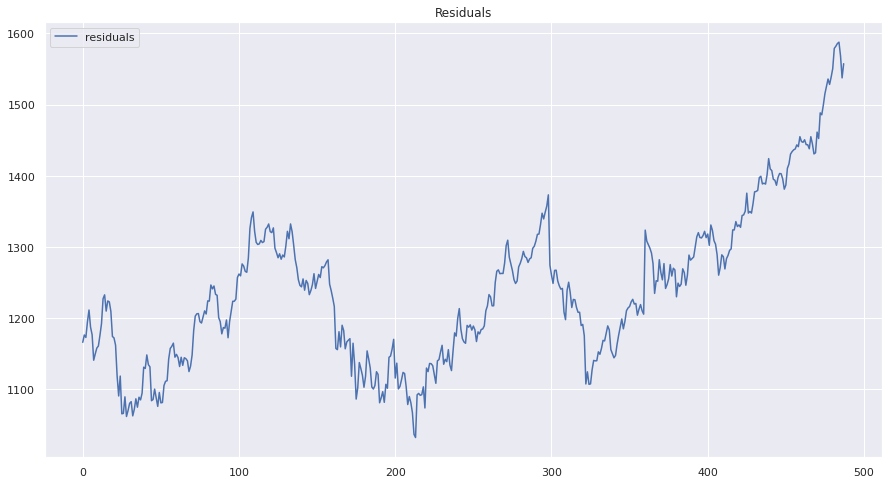

time: 437 ms (started: 2021-05-13 07:03:24 +00:00)


In [48]:
# Plot Residuals
sns.set(rc={'figure.figsize':(15, 8)})
res.plot(title='Residuals')

#### **Calculate RMSE & Plot**

In [49]:
# Inverse original data
data = scaler.inverse_transform(data)
data

array([[ 265.514771],
       [ 264.568329],
       [ 269.400208],
       ...,
       [1433.900024],
       [1452.560059],
       [1458.630005]])

time: 12.1 ms (started: 2021-05-13 07:03:24 +00:00)


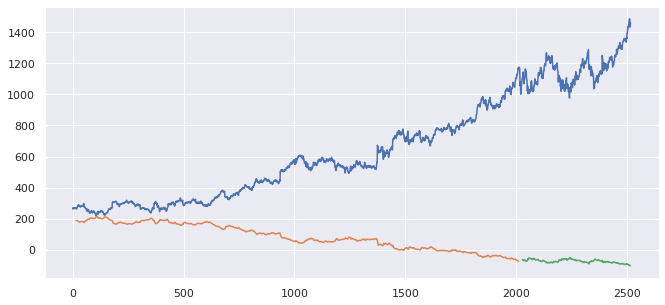

time: 344 ms (started: 2021-05-13 07:03:24 +00:00)


In [50]:
# Plot results

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [51]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 1243.45 RMSE
time: 2.41 ms (started: 2021-05-13 07:03:25 +00:00)


In [52]:
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

time: 1.21 ms (started: 2021-05-13 07:03:25 +00:00)
